In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import StandardScaler, Normalizer
import seaborn as sns
plt.style.use('seaborn-whitegrid') 

## Table of contents

- Data Processing and feature engineering 

- Random Forest model and feature importances 

- Logistic regression model and feature weights

- Considerations and next steps

## Data processing 

In [3]:
df = pd.read_csv('./data/HR_Data.csv')
df.columns

Index(['EmployeeID', 'Age', 'Gender', 'MaritalStatus', 'Education_Level',
       'EducationField', 'BusinessTravel', 'Department', 'Commute',
       'MonthlyIncome', 'MonthlyRate', 'DailyRate', 'HourlyRate', 'Grade',
       'Role', 'Satisfaction', 'NumCompaniesWorked', 'OverTime',
       'TotalExperienceYears', 'YearsInCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithLineManager', 'Attrition'],
      dtype='object')

### Dataset Statistics

In [4]:
df[['Age', 'MonthlyIncome','Commute', 'YearsInCompany', 'YearsInCurrentRole','YearsSinceLastPromotion']].describe()[1:]

,Age,MonthlyIncome,Commute,YearsInCompany,YearsInCurrentRole,YearsSinceLastPromotion
mean,36.923810,6502.931293,9.192517,7.008163,4.229252,2.187755
std,9.135373,4707.956783,8.106864,6.126525,3.623137,3.222430
min,18.000000,1009.000000,1.000000,0.000000,0.000000,0.000000
25%,30.000000,2911.000000,2.000000,3.000000,2.000000,0.000000
50%,36.000000,4919.000000,7.000000,5.000000,3.000000,1.000000
75%,43.000000,8379.000000,14.000000,9.000000,7.000000,3.000000
max,60.000000,19999.000000,29.000000,40.000000,18.000000,15.000000


<AxesSubplot:>

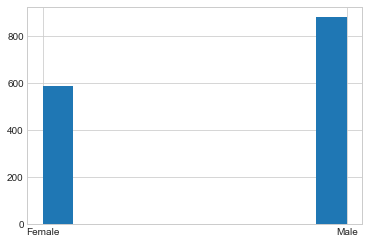

In [5]:
df.Gender.hist()

<AxesSubplot:>

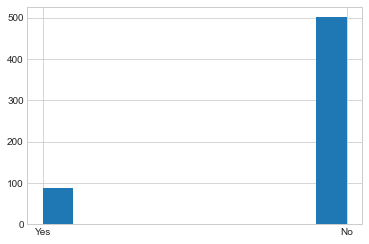

In [6]:
df[df.Gender=='Female'].Attrition.hist()

<AxesSubplot:>

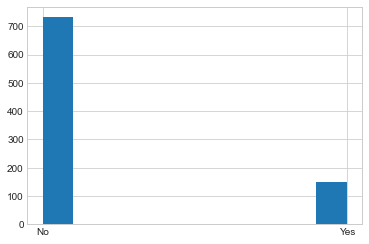

In [7]:
df[df.Gender=='Male'].Attrition.hist()

<AxesSubplot:>

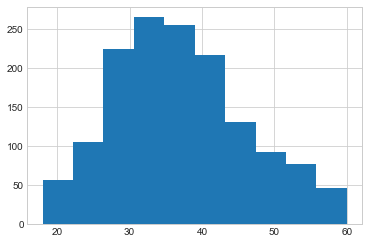

In [8]:
df.Age.hist()

<AxesSubplot:>

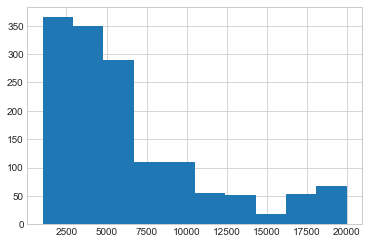

In [9]:
df.MonthlyIncome.hist()

<AxesSubplot:>

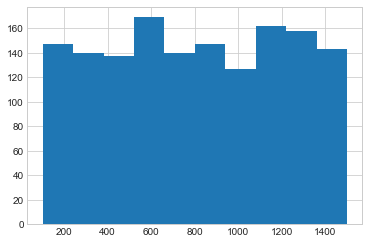

In [10]:
df.DailyRate.hist()

<AxesSubplot:>

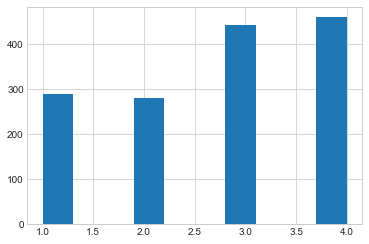

In [11]:
df.Satisfaction.hist()

In [12]:
df.columns

Index(['EmployeeID', 'Age', 'Gender', 'MaritalStatus', 'Education_Level',
       'EducationField', 'BusinessTravel', 'Department', 'Commute',
       'MonthlyIncome', 'MonthlyRate', 'DailyRate', 'HourlyRate', 'Grade',
       'Role', 'Satisfaction', 'NumCompaniesWorked', 'OverTime',
       'TotalExperienceYears', 'YearsInCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithLineManager', 'Attrition'],
      dtype='object')

## Feature Engineering 

Transform categorical columns to 1-hot representation in order to be used from ML models.

We are also dropping `Age` and `Gender` columns to avoid injecting bias to the models 


In [13]:
#df= df.drop( "Gender", axis=1)
#df= df.drop( "Age", axis=1)
categorical_cols = [
                    "Gender", 
                    "EducationField", 
                    "MaritalStatus", 
                    "OverTime", 
                    "BusinessTravel", 
                    "Department", "Role",
                   ]


Uni, Msc , Phd

Uni [1, 0, 0 ]
Msc [0, 1, 0 ]
Phd [0, 0, 1]

## 1-hot encoding of the categorical variables

In [14]:
dummies = None  
for col in categorical_cols:
    print(col)
    tmp = pd.get_dummies( df[col], prefix=col + "_")
    if dummies is None:
        dummies= tmp
    else:
        dummies = dummies.merge(tmp, left_index=True, right_index=True)
    
dummies.head()

Gender
EducationField
MaritalStatus
OverTime
BusinessTravel
Department
Role


,Gender__Female,Gender__Male,EducationField__Business,EducationField__Engineering,EducationField__Health Science,EducationField__Human Resources,EducationField__Other,EducationField__Social Sciences,MaritalStatus__Divorced,MaritalStatus__Married,...,Department__Sales,Role__Healthcare Representative,Role__Human Resources,Role__Laboratory Technician,Role__Manager,Role__Manufacturing Director,Role__Research Director,Role__Research Scientist,Role__Sales Executive,Role__Sales Representative
0,1,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0


In [15]:
other_cols = [ c for c in df.columns if c not in categorical_cols]
other_cols
df_pred = df[other_cols].copy()

In [16]:
df_all = df_pred.merge(dummies, left_index=True, right_index=True)

In [17]:
target = df_all[['Attrition']].copy()
df_all = df_all.drop(labels=["EmployeeID", 'Attrition'], axis=1)

In [18]:
target['Attrition'] =  target['Attrition'].map( lambda k: 1 if k =='Yes' else 0)

In [19]:
X = df_all.values
columns = df_all.columns

y = target.Attrition.values

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42)

## Fit a Random Forest to the data


In [21]:
clf = RandomForestClassifier(random_state=42,  n_estimators=100)

## Cross-validate the model with f1-macro score

Since the labels are imbalanced, accuracy is not a good metric. Here instead, we are using f1-micro score,
which takes into account true positives, false negatives and false positives.

$f1  = 2 * \frac{precision*recall}{precision\cdot recall} $ 

where 
$ precision = \frac{tp}{tp+tf}$ and 

$recal = \frac{tp}{tp+fn}$

In [22]:
ret = cross_val_score(clf, X,y, cv = 10  , scoring='f1_micro')

print( f"f1-score {np.mean(ret)}")

f1-score 0.8544217687074829


In [23]:
clf.fit(X, y)

RandomForestClassifier(random_state=42)

## Get the top 10 most important features of the forest

Here, we are going to be using the random forest impurity-based feature importance of RandomForestClassifier, followed by the feature-permutation based importance 

Feature ranking:
1. Age - [feat 3],  (0.082168)
2. Education_Level - [feat 0],  (0.071194)
3. Commute - [feat 4],  (0.061447)
4. MonthlyIncome - [feat 5],  (0.061369)
5. MonthlyRate - [feat 10],  (0.058817)
6. DailyRate - [feat 2],  (0.058688)
7. HourlyRate - [feat 6],  (0.058280)
8. Grade - [feat 11],  (0.046342)
9. Satisfaction - [feat 9],  (0.039615)
10. NumCompaniesWorked - [feat 14],  (0.038402)


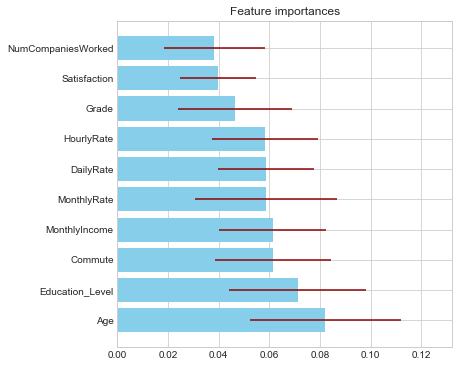

In [24]:
NUM_FEATS = 10 
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")


for f in range(NUM_FEATS):
    print("%d. %s - [feat %d],  (%f)" % (f + 1, columns[f], indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure( figsize= (6,6))
plt.title("Feature importances")


plt.barh(range(NUM_FEATS), importances[indices[0:NUM_FEATS]],
        color="#87ceeb", xerr=std[indices[0:NUM_FEATS]], align="center",  ecolor='darkred', linestyle=':')

plt.yticks(range(NUM_FEATS), columns[0:NUM_FEATS], rotation=0)
plt.xlim([0, max(importances)+.05])
plt.show()

## Feature importance using permutation importance

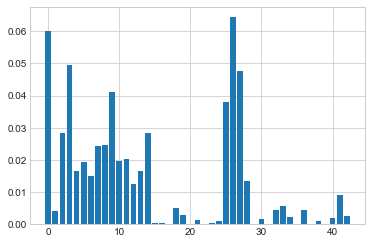

In [25]:
NUM_FEATS = 10
results = permutation_importance(clf, X, y, scoring='f1_macro')
# get importance
importances = results.importances_mean
std = np.std( results.importances, axis =1) 

 
# plot feature importance
plt.bar([x for x in range(len(importances))], importances)
plt.show()

In [26]:
imp_columns = []
feat_inds = []
indices = np.argsort(importances)[::-1]

for ind in indices[0:NUM_FEATS]:
    imp_columns.append( columns[ind])
    feat_inds.append( ind )
    
    
feat_inds, imp_columns

([26, 0, 3, 27, 9, 25, 2, 14, 8, 7],
 ['OverTime__No',
  'Age',
  'MonthlyIncome',
  'OverTime__Yes',
  'NumCompaniesWorked',
  'MaritalStatus__Single',
  'Commute',
  'YearsWithLineManager',
  'Satisfaction',
  'Grade'])

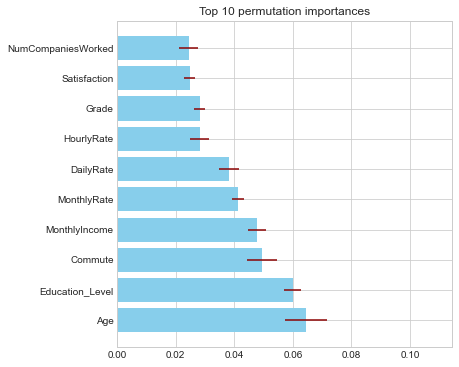

In [27]:
# Plot the permutation-based feature importances of the forest
plt.figure( figsize= (6,6))
plt.title(f"Top {NUM_FEATS} permutation importances")


plt.barh(range(NUM_FEATS), importances[indices[0:NUM_FEATS]],
        color="#87ceeb", xerr=std[indices[0:NUM_FEATS]], align="center",  ecolor='darkred', linestyle=':')

plt.yticks(range(NUM_FEATS), columns[0:NUM_FEATS], rotation=0)
plt.xlim([0, max(importances)+.05])
plt.show()

## Logistic Regression model

Here, we fit a logistic regression model to the data,
eg we model the probability of Attrition given the rest of the features

$$ p( Attrition=Yes | x, w )   = \frac{1}{ 1 + e^{ - w^T x  } }  $$
where $x$ is the feature vector and $w$ the model's weights.


Note that we are normalising input features to be in the range,  $x_i \in [0,1]$



In [28]:
scaler = StandardScaler() #Normalizer()


other_cols = [c for c in df.columns if c not in categorical_cols + ['Attrition']][1:]
other_cols
df_pred = df[other_cols].copy()


target=  df[['Attrition']].copy()
target['Attrition'] =  target['Attrition'].map( lambda k: 1 if k =='Yes' else 0)
y = target.Attrition.values


x1 =  scaler.fit_transform( df_pred.values )
X = np.concatenate( [x1, dummies.values], axis=1)

columns = list(dummies.columns) + other_cols

X.max(), X.min(), len(columns)

(5.386914010062064, -2.072192177156677, 43)

## Cross validate the model with 5 fold-cv and f1 scoring

In [29]:
model = LogisticRegression( random_state = 0, fit_intercept = False)
ret=cross_val_score(model, X,y, cv = 5  , scoring='f1_micro')
ret, np.mean(ret)


(array([0.85034014, 0.8707483 , 0.8707483 , 0.84353741, 0.88095238]),
 0.863265306122449)

In [30]:
model.fit(X,y)

LogisticRegression(fit_intercept=False, random_state=0)

## Plot model weights 

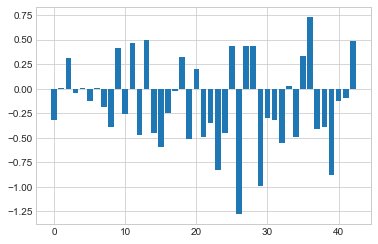

In [31]:
importances = model.coef_[0]
plt.bar([x for x in range(len(importances))], importances)
plt.show()

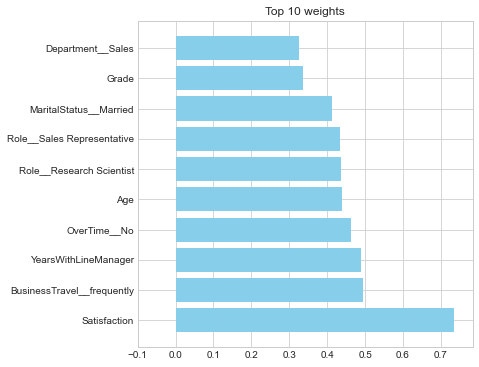

In [32]:
NUM_FEATS = 10

indices = np.argsort(importances)[::-1]
imp_columns = []
feat_inds  = []
for ind in indices[0:NUM_FEATS]:
    imp_columns.append( columns[ind])
    feat_inds.append( ind )
    
    
    
# Plot the top-k weights 
plt.figure( figsize= (6,6))
plt.title(f"Top {NUM_FEATS} weights")

plt.barh(range(NUM_FEATS), importances[indices[0:NUM_FEATS]],
        color="#87ceeb", #xerr=std[indices[0:NUM_FEATS]],
         align="center",  ecolor='darkred', linestyle=':')

plt.yticks(range(NUM_FEATS), imp_columns, rotation=0)
plt.xlim([-.1, max(importances)+.05])
plt.show()

## Pipeline





In [54]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('pca', PCA(n_components = 40)), 
                 ('lr', LogisticRegression())
                ])


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=40)),
                ('lr', LogisticRegression())])

In [55]:
ret = pipe.predict( X_test) 
accuracy_score( y_test,ret )

0.8885869565217391

## Considerations and  Next steps


### Gender and age sensitive models 

Here, in this model we choose not to use gender and age as a predictors, which can potentially cause bias problems and data sensitivity issues. By including these two predictors in the model, the output of the models are comparable. However, in different scenarios special care must be taken to ensure there is no gender, age or any other bias introduced.

There are several ways to detect and deal with bias, including parallel models with/without specific predictiors, flipping predictors like age etc.  


### Further optimisation


The models described in this notebook are not optimised, in the sense that there is no exaustive search for optimal hyper-parameters with respect the problem's metric. 


We can do that by employing a search method (typically grid search, randomized search or Bayesian Optimisation with Gaussian Processes, to name a few).




### Additional data 

One important class of features that can be added to this model is to include more employee satisfaction features. Currently this is reflected with **Satisfaction** and **YearsSinceLastPromotion** columns in the data.  However other factors maybe very important as well, for example years since last training, per individual preferences on flexible working hours if present, days of annual leave etc.




